In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import roc_curve, auc

In [2]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED'] = str(42)
   tf.random.set_seed(42)
   tf.keras.utils.set_random_seed(42)
   np.random.seed(42)
   random.seed(42)

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def get_weighted_f1(y_true, y_pred):
    # Compute true positives, possible positives, and predicted positives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)

    # Compute precision, recall, and F1-score for each class
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate the weighted F1-score
    weights = possible_positives / K.sum(possible_positives)
    weighted_f1 = K.sum(f1_val * weights)

    return weighted_f1

def rearrangeData(x: np.ndarray):
    '''
    Transforma (nModels, nSamples, nLabels) en (nSamples, nModels*nLabels), juntando los valores de cada modelo correspondientes a la misma etiqueta.
    '''
    x_out = np.empty((x.shape[1], x.shape[0] * x.shape[2]))

    for idx in range(x.shape[1]):
        for jdx in range(x.shape[2]):
            for kdx in range(x.shape[0]):
                x_out[idx, (jdx * x.shape[0] + kdx)] = x[kdx, idx, jdx]
    
    return x_out

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.
    
    Parameters:
    history: History object returned by the fit method of a keras model.
    """
    # Get the history dictionary
    history_dict = history.history

    # Extract loss and accuracy values
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    metric_values = history_dict['get_weighted_f1']
    val_metric_values = history_dict['val_get_weighted_f1']

    epochs = range(1, len(loss_values) + 1)

    # Plot the training and validation loss
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss_values, label='Training')
    plt.plot(epochs, val_loss_values, label='Validation')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metric_values, label='Training')
    plt.plot(epochs, val_metric_values, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('weighted_f1')
    plt.legend()

## Modelo denso

In [3]:
data = np.load('results/experts.npz')

# Access individual arrays
x_train = data['x_train']
x_train = x_train.transpose(1, 0, 2).reshape(x_train.shape[1], x_train.shape[0] * x_train.shape[2])
y_train = data['y_train']
x_test = data['x_test']
x_test = x_test.transpose(1, 0, 2).reshape(x_test.shape[1], x_test.shape[0] * x_test.shape[2])
y_test = data['y_test']

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = x_train.shape[1]),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

2024-05-26 13:55:10.380333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 13:55:10.741935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 13:55:10.741986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 13:55:10.750265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 13:55:10.750334: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5258 (20.54 KB)
Trainable params: 5258 (20.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[get_f1, get_weighted_f1])

model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.05)

Epoch 1/10


2024-05-26 13:55:12.036730: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-26 13:55:12.530427: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6a78052d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-26 13:55:12.530487: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-05-26 13:55:12.536421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 13:55:12.573555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-05-26 13:55:12.654193: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 21ms/step - loss: 4.3277 - get_f1: 0.0000e+00 - get_weighted_f1: 0.0000e+00 - val_loss: 3.5117 - val_get_f1: 0.0000e+00 - val_get_weighted_f1: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 0s 8ms/step - loss: 3.8976 - get_f1: 0.0000e+00 - get_weighted_f1: 0.0000e+00 - val_loss: 3.1187 - val_get_f1: 0.0000e+00 - val_get_weighted_f1: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 3.5174 - get_f1: 0.0000e+00 - get_weighted_f1: 0.0000e+00 - val_loss: 2.7641 - val_get_f1: 0.0000e+00 - val_get_weighted_f1: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 3.1841 - get_f1: 0.0150 - get_weighted_f1: 0.0129 - val_loss: 2.4846 - val_get_f1: 0.0000e+00 - val_get_weighted_f1: 0.0000e+00
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 2.9129 - get_f1: 0.1537 - get_weighted_f1: 0.1161 - val_loss: 2.2645 - val_get_f1: 0.2909 - val_get_weighted_f1: 0

In [6]:
y_pred = model.predict(x_train)
y_pred = np.round(y_pred)

report = classification_report(y_train, y_pred, zero_division=0)
print(report)

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        69
           1       1.00      0.49      0.66       100
           2       1.00      0.19      0.31        70
           3       1.00      0.26      0.41       101
           4       1.00      0.13      0.23        71
           5       1.00      0.41      0.58       127
           6       1.00      0.69      0.82       150
           7       1.00      0.17      0.29        96
           8       1.00      0.42      0.59        86
           9       1.00      0.62      0.77       133

   micro avg       1.00      0.40      0.57      1003
   macro avg       1.00      0.36      0.50      1003
weighted avg       1.00      0.40      0.54      1003
 samples avg       0.79      0.58      0.64      1003



In [7]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

report = classification_report(y_test, y_pred, zero_division=0)
print(report)

2/2 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       1.00      0.38      0.55        16
           2       1.00      0.12      0.22         8
           3       1.00      0.07      0.13        14
           4       0.00      0.00      0.00         8
           5       1.00      0.33      0.50        15
           6       1.00      0.38      0.56        13
           7       1.00      0.25      0.40        12
           8       0.00      0.00      0.00         8
           9       1.00      0.76      0.87        17

   micro avg       0.97      0.28      0.44       124
   macro avg       0.80      0.24      0.34       124
weighted avg       0.87      0.28      0.39       124
 samples avg       0.61      0.37      0.44       124



## Modelo convolucional

In [3]:
data = np.load('results/experts.npz')
print(data['x_train'].shape)

# Access individual arrays
x_train = rearrangeData(data['x_train'])
y_train = data['y_train']
x_test = rearrangeData(data['x_test'])
y_test = data['y_test']

(3, 505, 10)


In [4]:
reset_random_seeds()
nModels = 3
nClasses = 10
nFilters = 2
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((nModels * nClasses, 1), input_shape = (nModels * nClasses,)),
    tf.keras.layers.Conv1D(nFilters, nModels, nModels, activation = 'relu', kernel_regularizer = l2(0.1)),
    tf.keras.layers.Reshape(target_shape = (nClasses * nFilters, 1)),
    tf.keras.layers.Conv1D(1, nFilters, nFilters, activation = 'sigmoid', kernel_regularizer = l2(0.01))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 30, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 10, 2)             8         
                                                                 
 reshape_1 (Reshape)         (None, 20, 1)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1)             3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-05-26 17:36:47.092216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:36:47.289448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:36:47.289505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:36:47.292077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:36:47.292151: I tensorflow/compile

In [5]:
reset_random_seeds()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', get_weighted_f1])

# Define callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, start_from_epoch = 160, restore_best_weights = True)

# Train the model with callbacks
history = model.fit(
    x_train, y_train, 
    epochs = 1000,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = early_stopping)

Epoch 1/1000


2024-05-26 17:36:48.587691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-05-26 17:36:48.696918: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-26 17:36:48.818804: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-26 17:36:50.149343: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f071c9e5d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-26 17:36:50.149421: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-05-26 17:36:50.154907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 17:36:50.227910: I ./tensorflow/compiler/jit/

8/8 [==============================] - 3s 67ms/step - loss: 0.8616 - accuracy: 0.7936 - get_weighted_f1: 0.0108 - val_loss: 0.8571 - val_accuracy: 0.7902 - val_get_weighted_f1: 0.0000e+00
Epoch 2/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.8540 - accuracy: 0.7960 - get_weighted_f1: 0.0107 - val_loss: 0.8495 - val_accuracy: 0.7922 - val_get_weighted_f1: 0.0000e+00
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.8465 - accuracy: 0.7978 - get_weighted_f1: 0.0112 - val_loss: 0.8421 - val_accuracy: 0.7961 - val_get_weighted_f1: 0.0000e+00
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.8393 - accuracy: 0.7989 - get_weighted_f1: 0.0109 - val_loss: 0.8350 - val_accuracy: 0.7980 - val_get_weighted_f1: 0.0000e+00
Epoch 5/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.8322 - accuracy: 0.7996 - get_weighted_f1: 0.0086 - val_loss: 0.8280 - val_accuracy: 0.8000 - val_get_weighted_f1: 0.0000e+00
Epoch 6/

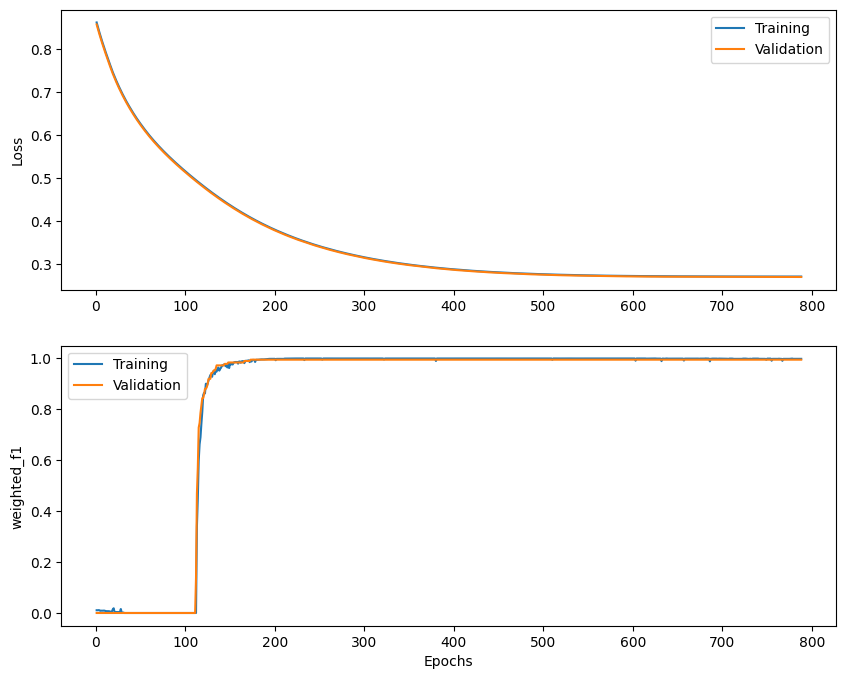

In [6]:
plot_training_history(history)

In [7]:
threshold = 0.21
results = model.predict(x_train)
y_pred = np.where(results.squeeze() < threshold, 0, 1)

report = classification_report(y_train, y_pred, zero_division=0)
print(report)

16/16 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00        70
           3       1.00      1.00      1.00       101
           4       1.00      1.00      1.00        71
           5       1.00      1.00      1.00       127
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00        96
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00       133

   micro avg       1.00      1.00      1.00      1003
   macro avg       1.00      1.00      1.00      1003
weighted avg       1.00      1.00      1.00      1003
 samples avg       1.00      1.00      1.00      1003



In [8]:
results = model.predict(x_test)
y_pred = np.where(results.squeeze() < threshold, 0, 1)

report = classification_report(y_test, y_pred, zero_division=0)
print(report)

2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.94      1.00      0.97        16
           2       0.70      0.88      0.78         8
           3       0.90      0.64      0.75        14
           4       1.00      0.75      0.86         8
           5       1.00      0.93      0.97        15
           6       0.70      0.54      0.61        13
           7       1.00      0.92      0.96        12
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        17

   micro avg       0.88      0.82      0.85       124
   macro avg       0.87      0.81      0.84       124
weighted avg       0.88      0.82      0.85       124
 samples avg       0.86      0.84      0.82       124



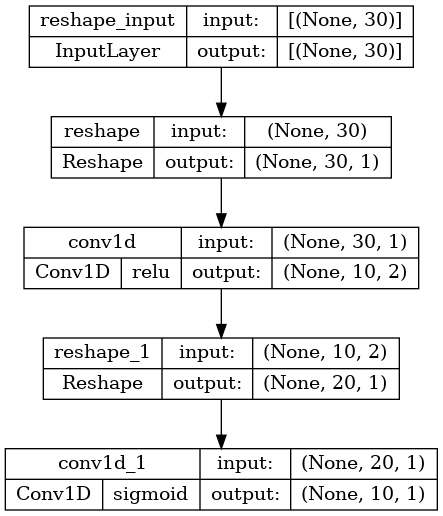

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file = 'results/images/model.png',
    show_shapes = True,
    show_layer_activations = True,
    rankdir = "TB")

In [15]:
def plot_roc_curve(y_pred_proba, y_train_test, title, save_filename):
    """
    - Calcula la curva ROC para cada clase individualmente y la curva ROC promedio.
    - Grafica las curvas ROC individuales por clase y la curva ROC promedio.
    - Guarda la figura en la carpeta 'results/images'.
    """
    # Transponer y_pred_proba
    y_pred_proba_np = np.array(y_pred_proba)
    y_pred_proba_np_transpose = np.transpose(y_pred_proba_np, (1, 0, 2))

    # Inicializar listas para almacenar los valores de fpr y tpr para cada clase
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    # Calculamos la curva ROC para cada clase individualmente
    for i in range(y_pred_proba_np_transpose.shape[1]):
        fpr, tpr, _ = roc_curve(y_train_test[:, i], y_pred_proba_np_transpose[:, i, 1])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(auc(fpr, tpr))

    # Calculamos la curva ROC promedio
    mean_fpr = np.unique(np.concatenate([fpr_list[i] for i in range(len(fpr_list))]))
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(len(fpr_list)):
        mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])

    mean_tpr /= len(fpr_list)
    roc_auc = auc(mean_fpr, mean_tpr)

    # Graficamos las curvas ROC individuales por clase
    plt.figure(figsize=(10, 6))
    for i in range(len(fpr_list)):
        plt.plot(fpr_list[i], tpr_list[i], label=f'ROC curve (area = {roc_auc_list[i]:.2f}) for class {i+1}', alpha=0.5)

    # Graficamos la curva ROC promedio
    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2.5, label=f'Average ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

    # Guardar la figura
    if not os.path.exists('./results/images'):
        os.makedirs('./results/images')
    plt.savefig(f'./results/images/{save_filename}.png', bbox_inches='tight')
    plt.show()

In [20]:
# Adapt NN output for ROC Curve
oneProbs = results.squeeze()
classificatorProb = []
for i in range(oneProbs.shape[1]):
    # Extract the i-th column
    column = oneProbs[:, i]
    # Create an (N, 2) array with the column values duplicated
    transformed_array = np.stack((1 - column, column), axis = 1)
    # Append to the list
    classificatorProb.append(transformed_array)

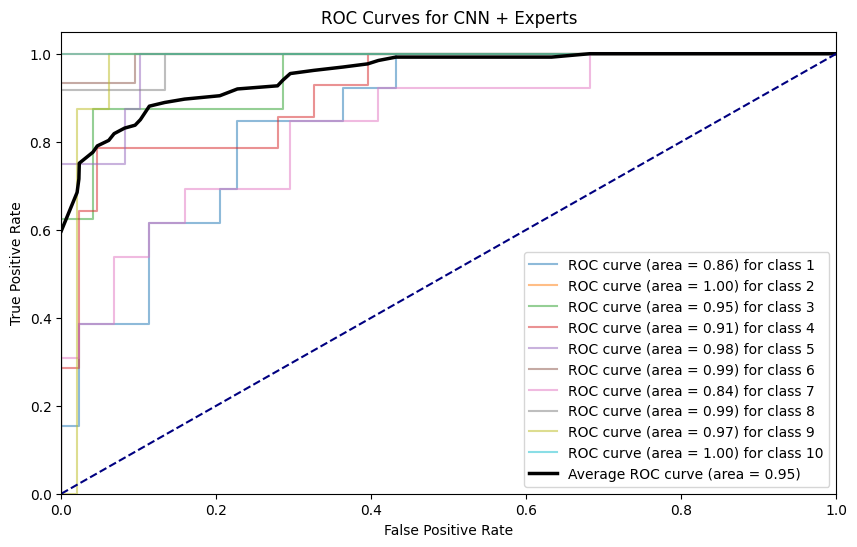

In [22]:
plot_roc_curve(classificatorProb, y_test, 'ROC Curves for CNN + Experts', 'cnn_roc_curve')